# **BÁO CÁO: TỐI ƯU HÓA CONVOLUTION KERNEL CỦA MÔ HÌNH LENET-5 BẰNG CUDA**

## **Danh sách thành viên và phân chia công việc**

### ***Thông tin thành viên***

|Họ và tên | MSSV |
|-------|-------|
| Nguyễn Việt Khoa | 20120120 |
| Nguyễn Đức Việt | 20120401 |
| Trần Thị Phương Linh | 20120521 |

### ***Phân chia công việc***

| STT | Công việc | Thành viên thực hiện | Tiến độ hoàn thành |
|---|---|---|---|
| 1 | Cài đặt để chạy kernel trên project starter | 20120401 | 100% |
| 2 | Cài đặt convolution cơ bản trên gpu | 20120401 | 100% |
| 3 | Cài đặt convolution kết hợp shared memory trên gpu | 20120120 | 100% |
| 4 | Cài đặt convolution kết hợp constant memory trên gpu | 20120120 | 100% |
| 5 | Cài đặt convolution với thuật toán unroll kết hợp nhân ma trận | 20120521 | 100% |

## **Giới thiệu chung về đồ án**

### ***Động lực thực hiện***
Đồ án nhằm mục đích áp dụng các kiến thức đã được học trên lớp về lập trình song song trên CUDA và các kiến thức tìm hiểu ở bên ngoài để triển khai và tối ưu việc song song hóa cho lớp convolution trong kiến trúc mạng LeNet-5

### ***Mô tả đồ án***
- Đồ án được dựa trên [starter project](https://github.com/iamhankai/mini-dnn-cpp) được giảng viên gợi ý trong file mô tả yêu cầu đồ án.
- Project trên đã cài đặt mạng Deep Neural Network trên CPU và huấn luyện trên tập MNIST. 
- Trong đồ án này, nhóm tiến hành thay đổi kiến trúc trong file demo sang kiến trúc LeNet-5 đã được yêu cầu trong file mô tả đồ án như dưới đây:

![lenet-5](./img/lenet-5.png)

- Nhóm cũng thực hiện thay thế tập MNIST bằng tập fashionMNIST mà đồ án yêu cầu.
- Kế đến, nhóm tiến hành cài đặt và tích hợp các kernel gpu (bao gồm kernel convolution cơ bản và các convolution tối ưu) vào starter project và kiểm tra, đánh giá kết quả.


### ***Chú thích***
 - `save_train_parameters.cc` dùng để lưu mảng trọng số sau khi train mô hình CNN bằng CPU.
 - `src/kernel/kernel` dùng để in thông tin của GPU.
 - `src/kernel/kernel_interface` implement các hàm `forward` chạy trên GPU.
 - `src/network` implement thêm 2 hàm `save_parameters` và `load_parameters` khi train mô hình CNN bằng CPU.
 - `src/dnn` dùng để tạo 2 mạng DNN CPU và GPU.

### ***Hướng dẫn khởi chạy***
- Mở file `run.ipynb` trên **Google Collab** để khởi chạy project.

### **I. Cài đặt tuần tự**

#### ***1. Phân tích***
Trong starter project trên, nhóm nhận thấy tác giả đã không chọn sử dụng thuật toán convolution thông thường mà chọn sử dụng thuật toán im2col và ứng dụng hàm nhân ma trận có sẵn của thư viện Eigen cho lớp convolution. (Thuật toán này sẽ được giải thích kỹ ở phần sau).
 

#### ***2. Đánh giá***

Trước hết, nhóm đã tiến hành quá trình huấn luyện mô hình trên tập dữ liệu và lưu trữ các tham số quan trọng cần thiết để sử dụng trong quá trình inference.

Tiếp theo, chúng tôi thực hiện quá trình inference trên tập test, bao gồm 10,000 mẫu, và đồng thời đo thời gian chạy để đánh giá hiệu suất của mô hình trên CPU.

Vì source code đã triển khai quá trình inference tuần tự, chúng tôi không thể kiểm tra tính chính xác trực tiếp. Tuy nhiên, nhóm đã thực hiện kiểm tra kỹ lưỡng về cấu trúc code và logic thuật toán để đảm bảo tính đúng đắn và hiệu quả của quá trình inference.

Kết quả thời gian chạy của CPU sẽ được sử dụng như một tiêu chí tham chiếu để so sánh với hiệu suất của GPU sau khi đã thực hiện song song hóa các phần quan trọng của mô hình trên CUDA.

Dưới đây là kết quả của cài đặt tuần tự trên CPU:

![lenet-5](./img/cpu.png)

### **II. Cài đặt cơ bản trên GPU**

#### ***1. Phân tích***
**a. Động lực:**
   - Hàm kernel `basic_conv_forward_kernel` được thiết kế để thực hiện phép toán convolution cơ bản trên GPU.

**b. Ý tưởng:**
   - Mỗi thread trong grid được giao việc tính toán một phần nhỏ của ma trận kết quả convolution.
   - Sử dụng ý tưởng chia ma trận đầu vào thành các phần nhỏ (tiles) để tối ưu hóa việc truy cập dữ liệu từ bộ nhớ.

#### ***2. Thuật toán***
- Các khối chia công việc theo chiều batch `(blockIdx.x)`, output feature `(blockIdx.y)`, và ma trận hình ảnh `(blockIdx.z)`.
- Mỗi khối chia thành các thread với `threadIdx.x` và `threadIdx.y` để xử lý từng phần của ma trận hình ảnh đầu vào.
- Tính toán chỉ số batch, output feature, hàng và cột của ma trận đầu ra để xác định vị trí cụ thể cần tính toán.
- Dùng `threadIdx` và `blockIdx` để tính toán chỉ số này.
- Khởi tạo biến `accumulator` với giá trị của bias tương ứng với output feature đang xử lý.
- Sử dụng vòng lặp để duyệt qua tất cả các kênh đầu vào (`input_channel`).
- Sử dụng hai vòng lặp lồng nhau để duyệt qua kernel `filter` với kích thước `kernel_size` x `kernel_size`.
- Tính toán vị trí đầu vào tương ứng trong ma trận đầu vào.
- Nhân giá trị đầu vào và giá trị kernel tương ứng, sau đó cộng vào biến `accumulator`.

#### ***3. Đánh giá***
**a. Hiệu suất:**
   - Code này tận dụng GPU để thực hiện tính toán convolution song song, nhanh chóng hơn so với việc thực hiện trên CPU.
   
   ![lenet-5](./img/gpu-0.png)

### **III. Cài đặt tối ưu hóa sử dụng unroll (im2col) kết hợp nhân ma trận**

#### ***1. Phân tích***:


**a. Động lực lựa chọn thuật toán**
  - Tận dụng được tính tối ưu của phép toán nhân ma trận trên GPU
  - Giúp cho việc thực hiện tính toán song song trên các convolution layer trở nên ổn định hơn.

**b. Ý tưởng:**
  - Thay vì thực hiện phép toán convolution như trước, ta sẽ thực hiện unroll input features để biến nó thành bài toán nhân ma trận. Tức là ta sẽ đi rải input features ra thành 1 ma trận sao cho mỗi cột của ma trận đó sẽ chứa các phần tử đảm nhận việc tạo ra một phần tử cho output feature (bằng cách tích vô hướng với mỗi dòng của ma trận weight).

**c. Nhận xét thuật toán:**
  - Mỗi phần tử của output feature cần $K*K$ phần tử của input feature.
  - Số lượng phần tử của ma trận unroll là $H_{out}*W_{out}*K*K*C$.
  - ***Ratio Expansion*** là tỉ lệ mở rộng của ma trận unroll so với ma trận input feature, công thức: $\frac{C*K*K*H_{out}*W_{out}}{C*H_{in}*W_{in}}$.
  - Nhìn chung thì nếu kích cỡ của input và output features lớn hơn rất nhiều so với ma trận weight thì tỉ lệ này sẽ dần tiến đến $K*K$.

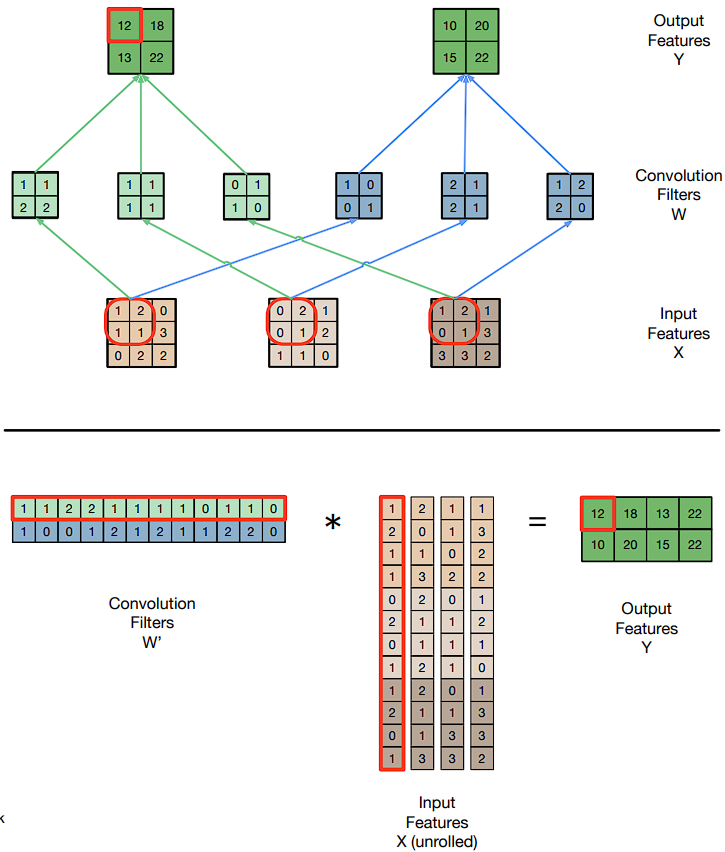

#### ***2. Thiết kế***
  

**Phân tích các bước đã tối ưu hóa trên GPU**
  - Ta tiến hành song song cho cả thuật toán unroll lẫn thuật toán nhân ma trận.
  - Ý tưởng song song hóa cho kernel unroll: Mỗi thread sẽ đảm nhận việc đọc ($K*K$) phần tử input từ một input feature map và viết nó vào ma trận unroll. Số thread cần sẽ là $C*H_{out}*W_{out}$
  - Ý tưởng song song hóa cho nhân ma trận: Áp dụng kernel nhân ma trận có sử dụng shared mem đã cài đặt ở lab về nhà.
  - ***Lưu ý nhỏ***: Vì starter project mà nhóm sử dụng đang lưu ma trận weight dưới dạng col-major nên trong phần code nhóm đã chỉnh sửa một chút thuật toán để phù hợp hơn (thay vì thực hiện phép nhân weight x input_unroll thì nhóm thực hiện input_unroll x weight và đồng thời transpose lại kết quả output)
  - Trong mô tả thuật toán ở trên, mặc dù nó chỉ giải quyết cho một sample nhưng ta có thể song song hóa để giải quyết cho từng batch bằng cách thêm chiều cho block size và grid size (batch_size nhóm lựa chọn là 128).
  - Nhóm cũng có cài đặt thêm cuda streams để tận dụng việc overlap giữa công việc đọc ghi dữ liệu và việc thực thi kernel. Mặc dù kết quả không được mấy tối ưu so với khi không sử dụng nhưng nhóm dự đoán là nếu được áp dụng vào những bài toán lớn hơn (khi mà thời gian đọc ghi gần bằng thời gian thực thi kernel) thì nó sẽ được tối ưu hơn.

#### ***3. Đánh giá***

**a. Tốc độ thực thi đo được trên tập test gồm 10000 mẫu dữ liệu**

![lenet-5](./img/gpu-1.png)

**b. Nhận xét:**
Tuy kết quả có chậm hơn một ít so với thuật toán basic, nhưng ta có thể lý giải được như sau: Điểm yếu của thuật toán basic là việc nó sẽ trở nên chậm hơn đối với các layer có số lượng output features lớn (tăng về số lượng nhưng giảm về kích thước). Đối với bài toán này, theo kiến trúc Lenet5, layer conv 1 và layer conv 2 có khá ít output features (layer 1 có 6 output features, layer conv 2 có 16 output features). Vậy nên tuy ta thấy thuật toán tối ưu có vẻ chậm hơn nhưng nếu được áp dụng vào các bài toán có nhiều lớp convolution hơn, khi số lượng output features tăng lên thì thuật toán này vẫn sẽ giữ được sự ổn định so với thuật toán basic.

### **IV. Cài đặt tối ưu hóa sử dụng Tiled Shared Memory**

#### **1. Phân tích:**
- Giảm thiểu số lần truy cập vào `Global Memory` bằng cách lưu dữ liệu đầu vào và trọng số convolution vào `Shared Memory` là **smem[]**.
- Việc này có thể giúp chương trình convolution thực hiện nhanh hơn vì việc truy cập vào `Global Memory` nhiều lần hao tốn thời gian hơn so với truy cập `Shared Memory`.

#### ***2. Thuật toán***
- Tiến hành khởi tạo cấu hình kernel CUDA tương tự như kernel naive cơ bản.
- Khởi tạo vùng nhớ `Shared Memory` được cấp phát động với kích thước là tổng của 2 phần:
    + Ma trận dữ liệu vào của ảnh có kích thước như sau: 
        $ TileSize = (InputSize + KernelSize - 1)^2 $ 
    + Ma trận trọng số convolution 5x5.
- Với mỗi block, `SMEM` sẽ lưu trữ bằng cách:
    + Mỗi thread có các index nằm trong kích thước kernel, sẽ đưa dữ liệu trọng số của lớp đặc trưng **m** vào **k_s**.
    + Các dữ liệu đưa vào **x_s** bằng cách tương tự như các bài lab.
- Thực hiện tính *accumulator* ở mỗi thread với bias của lớp đặc trưng tương ứng. 

    ![tiled.jpg](./img/tiled.jpg)

#### ***3. Đánh giá***
- Kết quả chương trình:

![lenet-5](./img/gpu-2.png)

- Nhận xét về kết quả:
    + Về kết quả: Các lớp đặc trưng tương tự như thực thi với CPU hay GPU chưa được tối ưu.
    + Về thời gian thực thi: Khác với mong đợi, chương trình có thời gian thực thi lâu hơn so với thực thi Convolution thông thường với GPU. Điều này có thể là bởi việc lưu các dữ liệu cần thiết vào `Shared Memory` phần nào làm tăng thời gian xử lý cho mỗi *thread* bởi **__syncthreads()** khiến các *thread* phải chờ đợi để tiếp tục xử lý. Trong khi đó việc các ảnh trong bộ dữ liệu `FASHION-MNIST` có kích thước nhỏ nên ý nghĩa của việc giảm thời gian truy cập của `Shared Memory` không có quá nhiều ý nghĩa khi chênh lệch giữa chương trình ***TILE SHARED MEMORY CONVOLUTION*** có số lần truy cập bộ nhớ so với `GMEM` CONVOLUTION bằng GPU thông thường không quá nhiều.